In [3]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


CPU times: user 718 ms, sys: 625 ms, total: 1.34 s
Wall time: 1.34 s


In [4]:
%%time
# 셔플, 미니배치, 프리페치 파이프라인 코드 삽입 및 batch_size = 128 로 증가
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

CPU times: user 1.46 s, sys: 2.12 s, total: 3.57 s
Wall time: 3.57 s


In [5]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 7.63 µs


In [6]:
%%time
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 7.61 ms, sys: 1.4 ms, total: 9.01 ms
Wall time: 7.94 ms


In [8]:
%%time
# 학습 루프
history = model.fit(train_dataset, batch_size=batch_size, epochs=100)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/100
391/391 [==============================] - 90s 107ms/step - loss: 1.3492 - accuracy: 0.5191
Epoch 2/100
391/391 [==============================] - 42s 107ms/step - loss: 0.8195 - accuracy: 0.7117
Epoch 3/100
391/391 [==============================] - 43s 110ms/step - loss: 0.6047 - accuracy: 0.7879
Epoch 4/100
391/391 [==============================] - 44s 112ms/step - loss: 0.4675 - accuracy: 0.8375
Epoch 5/100
391/391 [==============================] - 43s 111ms/step - loss: 0.3660 - accuracy: 0.8723
Epoch 6/100
391/391 [==============================] - 44s 111ms/step - loss: 0.2746 - accuracy: 0.9042
Epoch 7/100
391/391 [==============================] - 44s 111ms/step - loss: 0.2028 - accuracy: 0.9291
Epoch 8/100
391/391 [==============================] - 44s 111ms/step - loss: 0.1459 - accuracy: 0.9481
Epoch 9/100
391/391 [==============================] - 44s 111ms/step - loss: 0.1147 - accuracy: 0.9594
Epoch 10/100
391/391 [==============================] - 44s 111m

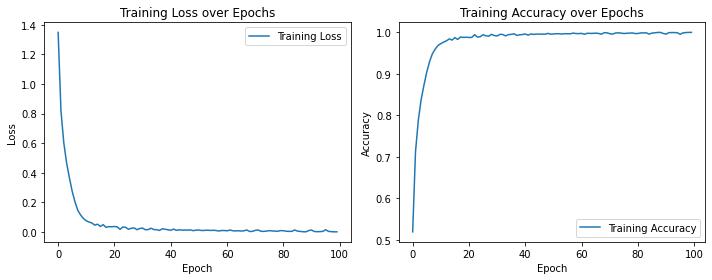

CPU times: user 592 ms, sys: 375 ms, total: 967 ms
Wall time: 571 ms


In [9]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# batch_size = 128 로 증가
# 에폭 100회 연산 시간 : 1: 16 : 19
# Train acc : 0.99
# Test acc : 0.83
# Test loss : 1.2653
# Test01의 평균 에폭 시간이 50초 였는데 평균 에폭 시간이 44초로 감소
# batch_size를 2배 늘렸으나 개인적인 예상인 40초로 평균 에폭시간이 감소될줄 알았으나 그만큼 감소하지는 않았음.
# Test03를 통해 얼마나 더 감소하는지 지켜볼 예정